In this project, I am working on advanced lane finding

## Table of Contents

Here I am showing the structure of the notebook and also acknowledging the sources I took help from, for each section

1. [Camera Calibration](#camera_calibration) - ***./examples/example.ipynb***
2. [Undistort Image](#undistort_image) - ***lesson 6 Part 12 quiz solution***
3. [Perspective Transform](#perspective_transform) - ***Jeremy shannon project [here](https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb)***
4. [Convert RGB image into Binary](#convert_to_binary) - ***lesson 7 part 12 quiz solution***
5. [Finding Lane Pixels](#finding_lane_pixels) - ***Lesson 8 Part 4 quiz solution***
6. [Radius Of Curvature](#radius_of_curvature) - ***Lesson 8 part 7 quiz solution***
7. [Testing on Test Images](#testing_on_test_images) -  ***putting text code block was from jeremy shannons blog***
8. [Video Pipeline](#video_pipeline) - ***putting text code block was from jeremy shannons blog***
9. [Search from Prior](#search_prior) ***Lesson 8 Part 5 quiz solution***

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from camera import Camera
from preprocess import PerspectiveTransformer
import util
import os
%matplotlib qt
%matplotlib inline

In [4]:
import tqdm

<a id="camera_calibration">
</a>

## Camera Calibration

In this section , I am writing code to calibrate camera. I have used codes from the ```example.ipynb``` provided with this repository. 

At first, we are calculating the calibration matrices. 

In [5]:
H = 720
W = 1280
IMG_SIZE = (H,W)

In [6]:
camera_cal_output_dir = "result/camera_cal/"
os.makedirs(camera_cal_output_dir, exist_ok=True)

undistort_output_dir = "result/undistort/"
os.makedirs(undistort_output_dir, exist_ok=True)

In [7]:
camera = Camera(IMG_SIZE)

In [8]:
imgs = util.load_img_from_dir("camera_cal")


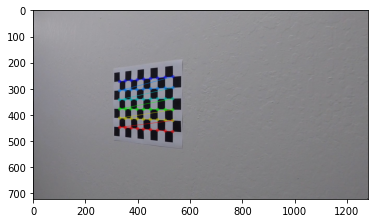

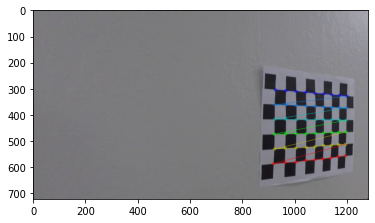

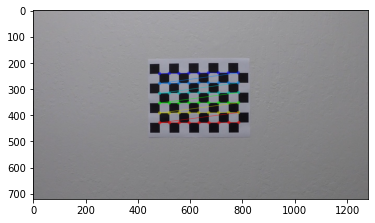

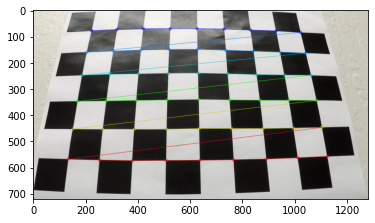

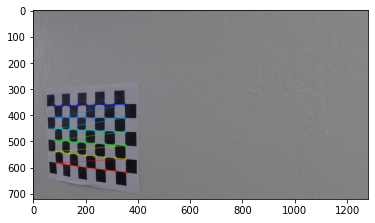

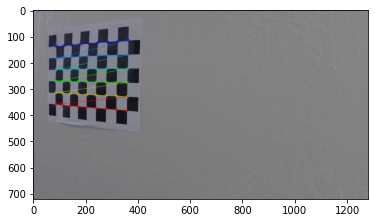

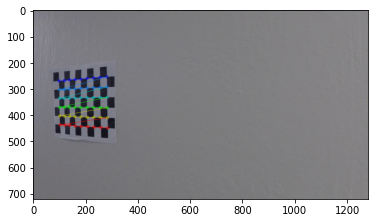

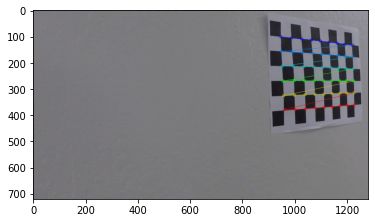

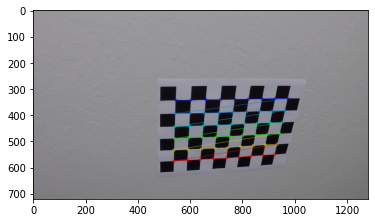

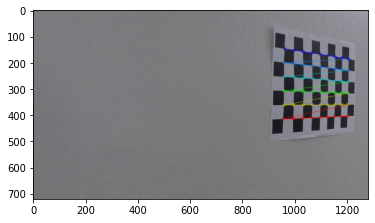

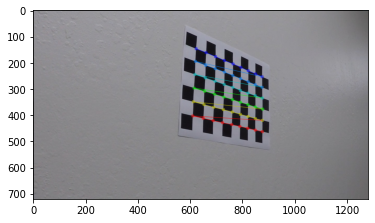

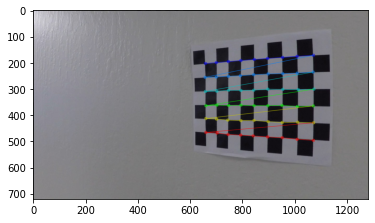

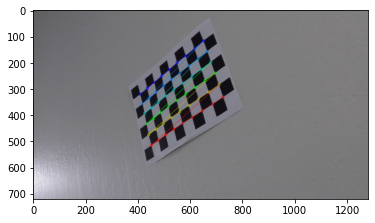

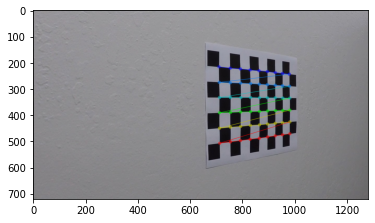

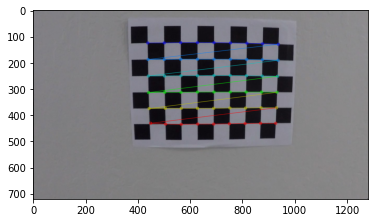

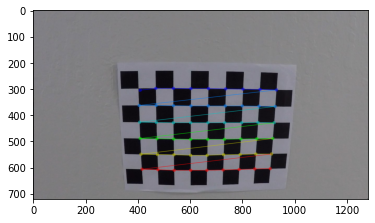

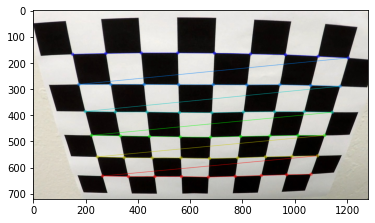

In [9]:
for i, img in enumerate(imgs):
    camera.set_img_points(img, plot=True, save_fig=True, fig_name=os.path.join(camera_cal_output_dir,"{}.jpg".format(i)))
    

The calibration matrix

In [10]:
calibration_matrix, _ = camera.get_calibration_matrix()

In [11]:

print(calibration_matrix)

[[1.15777930e+03 0.00000000e+00 6.67111053e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Resulting images

The undistorted images. Note: not all undistortions are noticeable as not all distortions can be noticed easily

In [12]:
imgs = util.load_img_from_dir('camera_cal/')

20it [00:07,  2.73it/s]


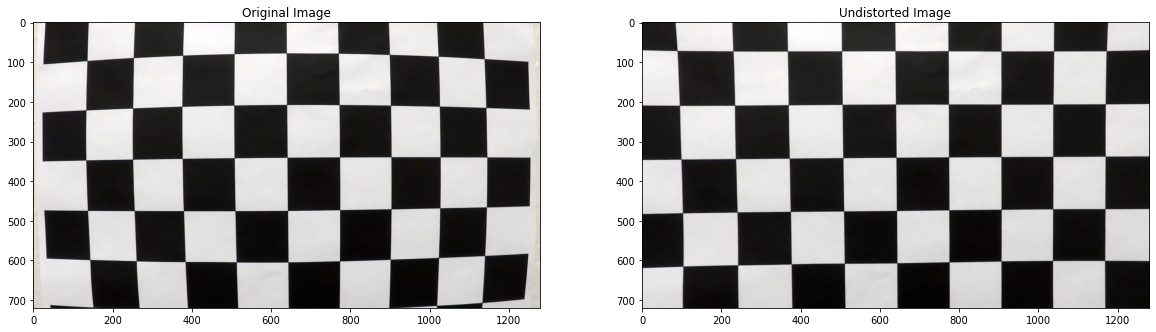

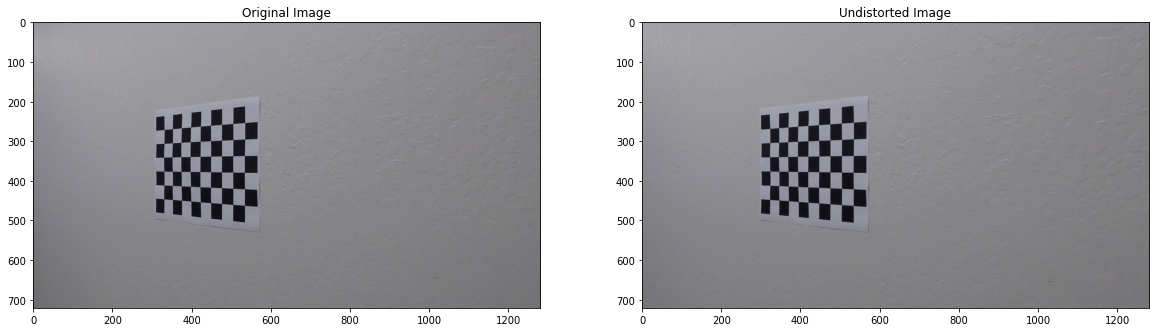

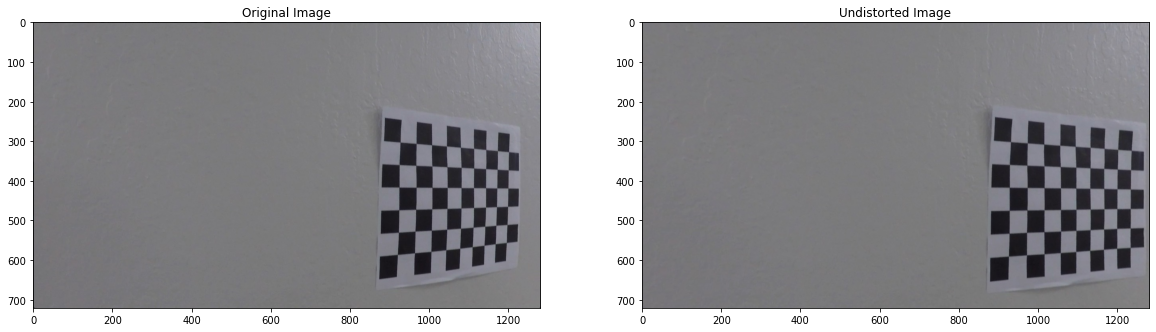

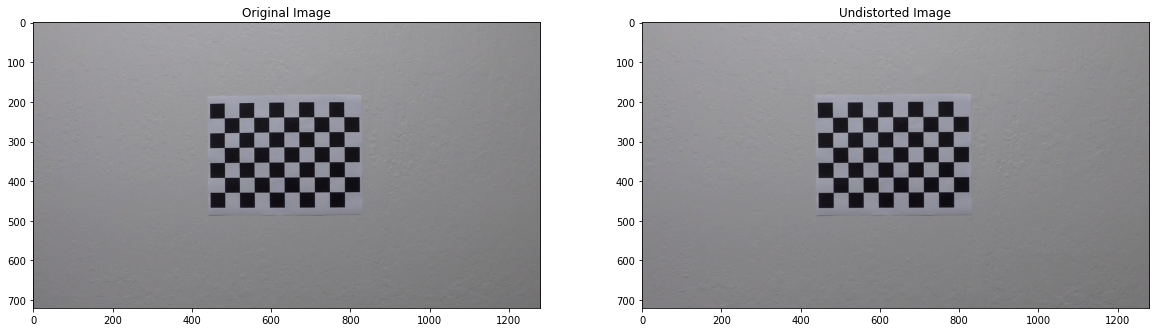

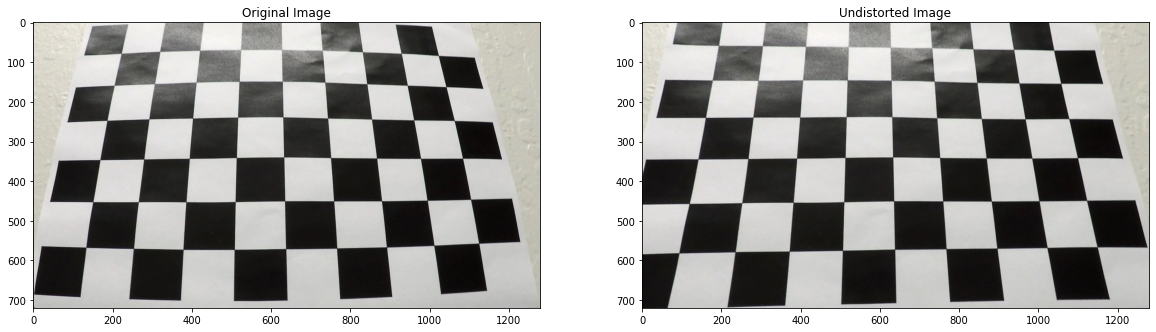

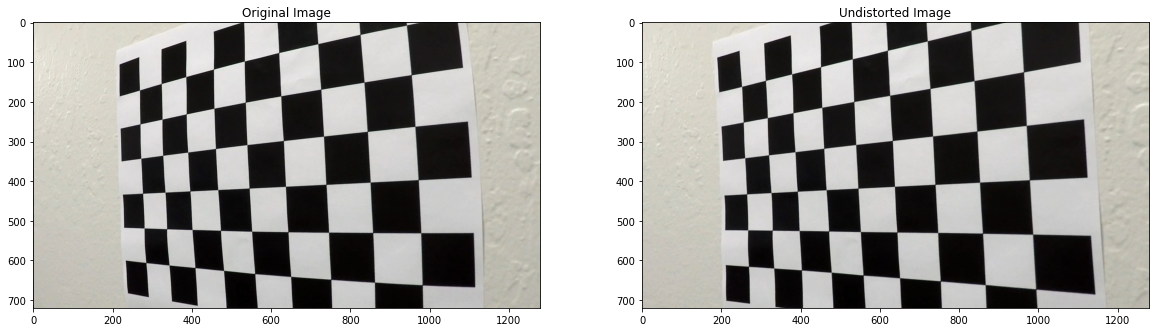

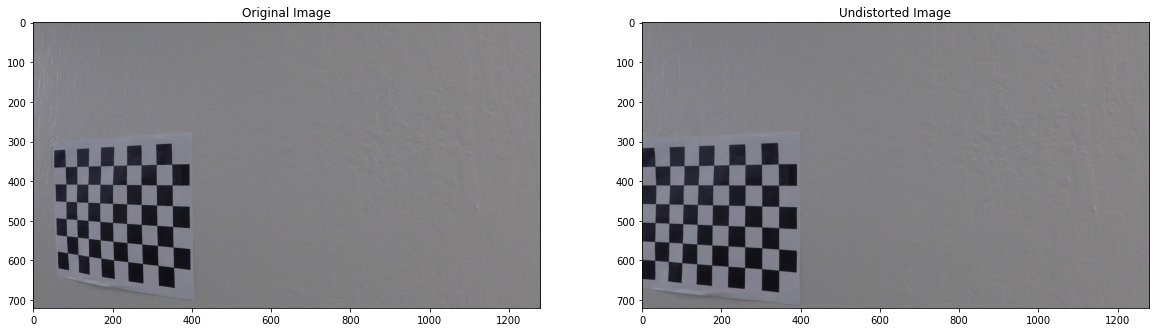

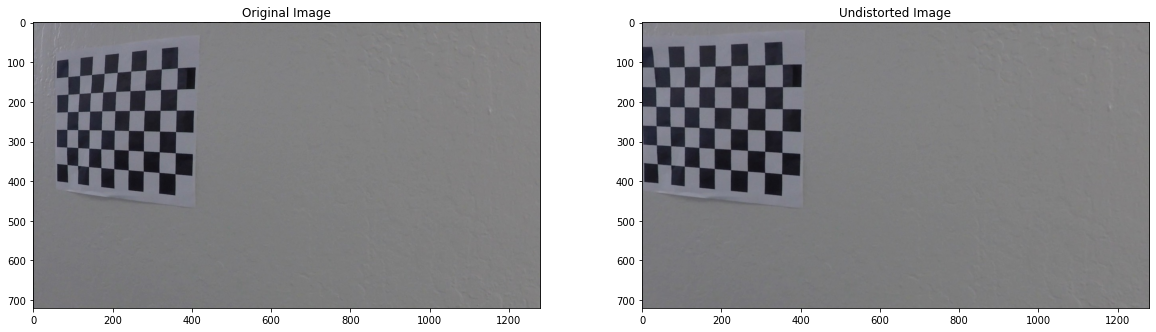

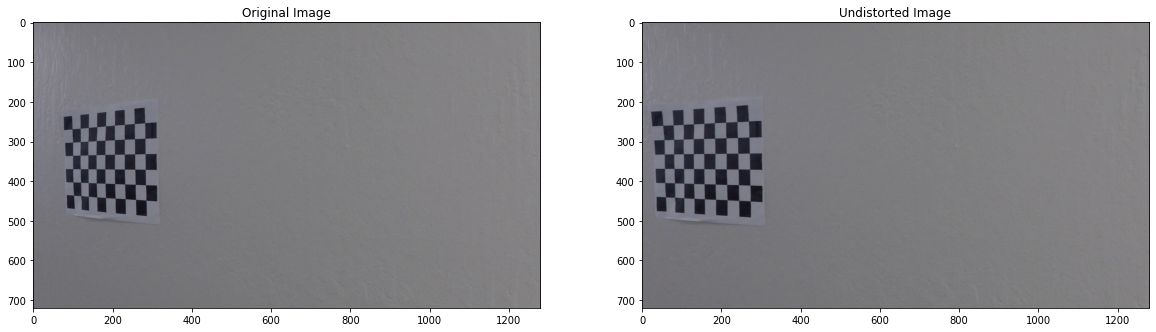

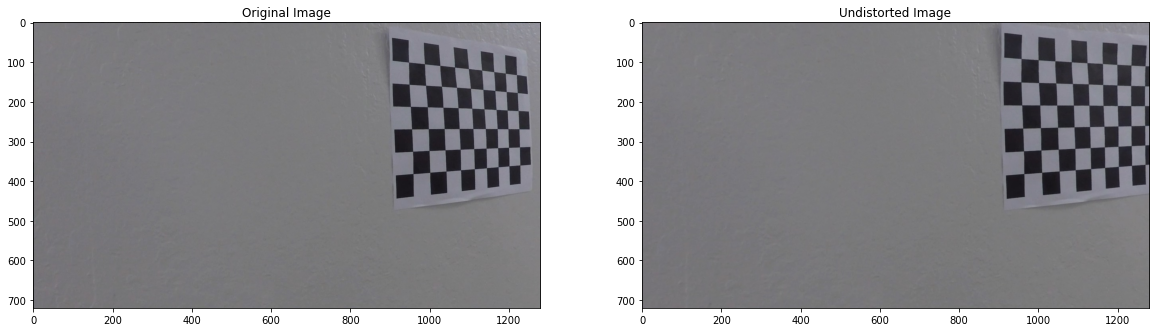

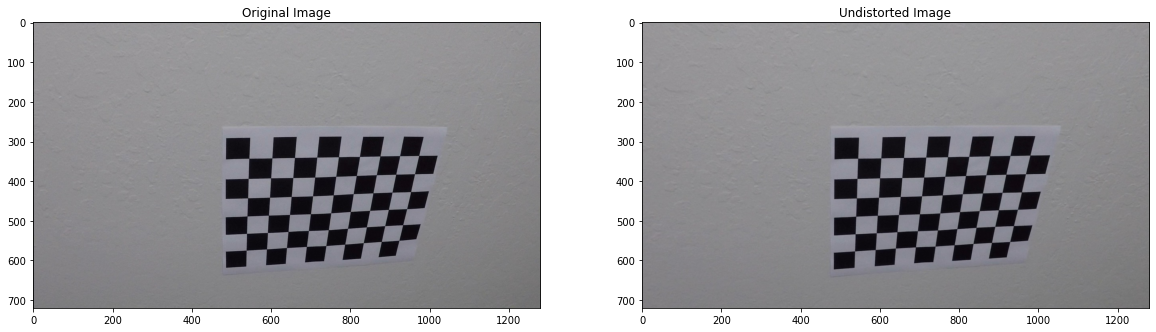

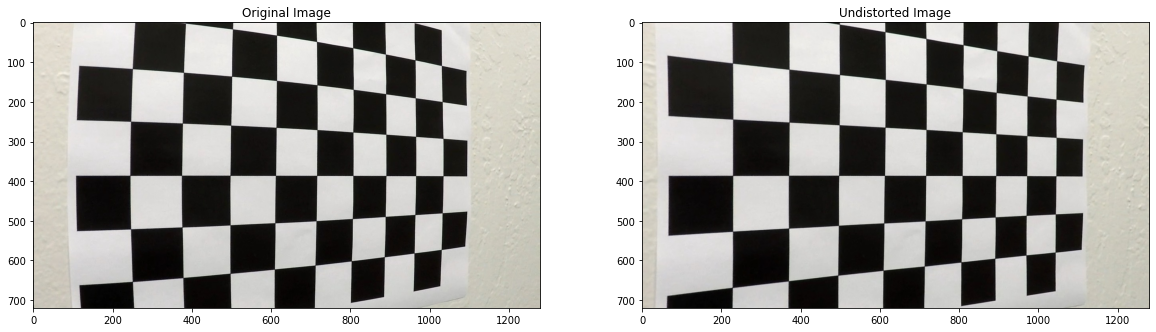

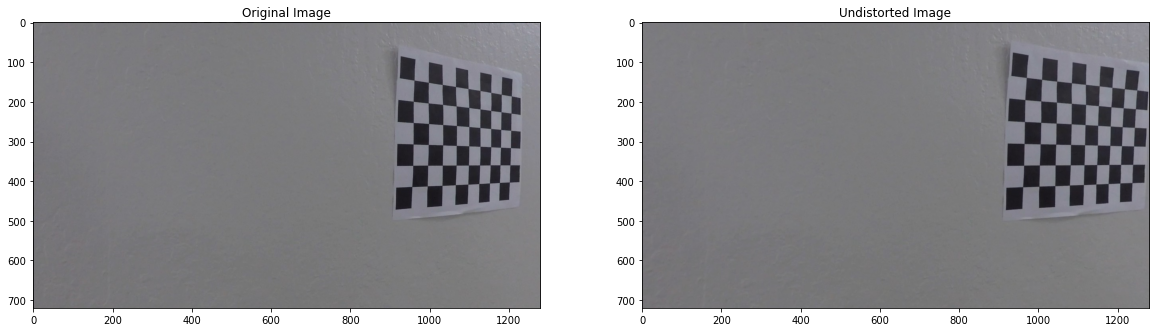

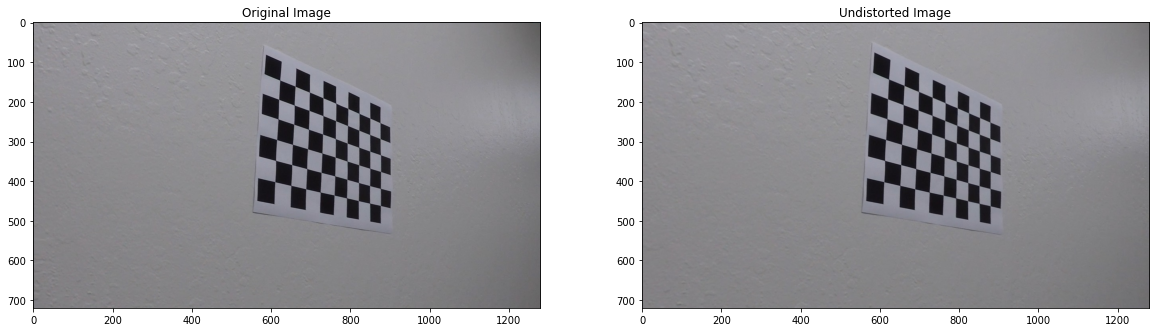

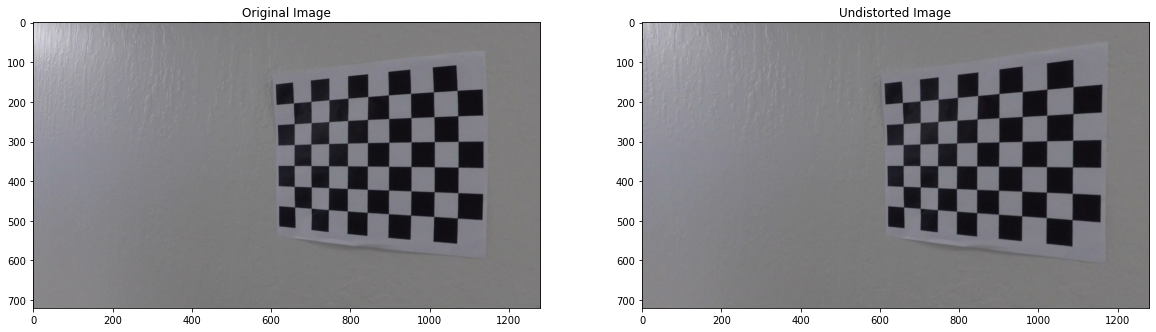

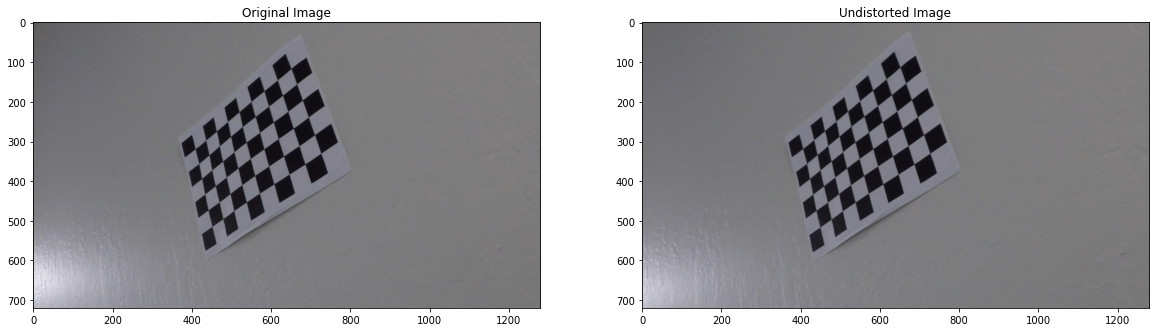

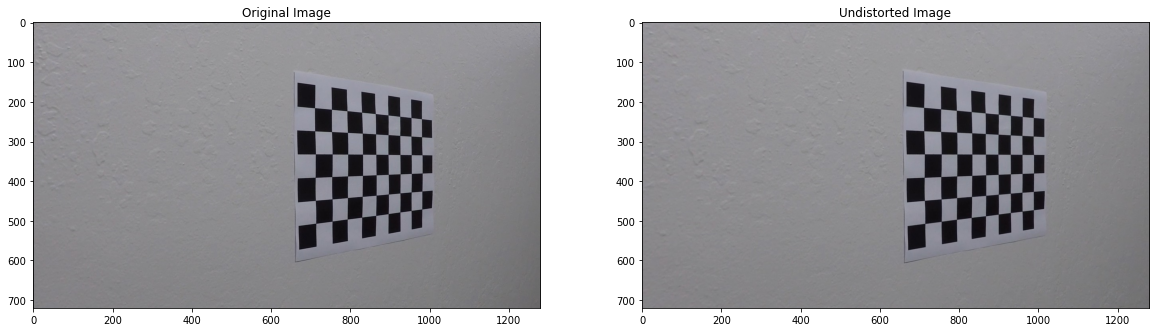

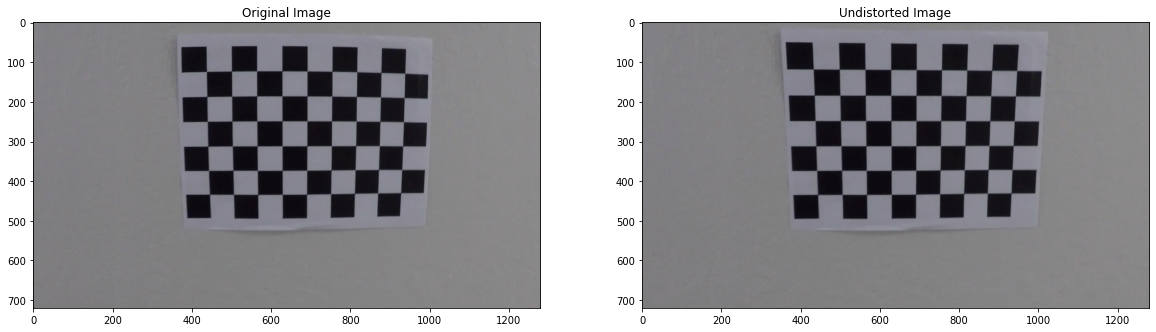

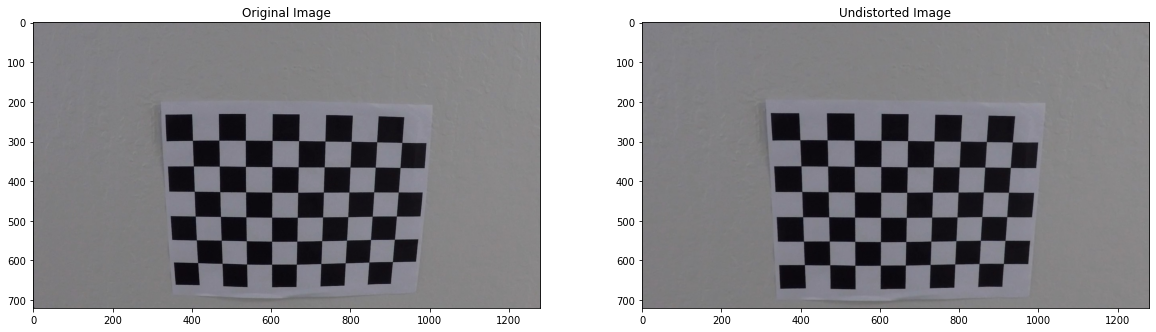

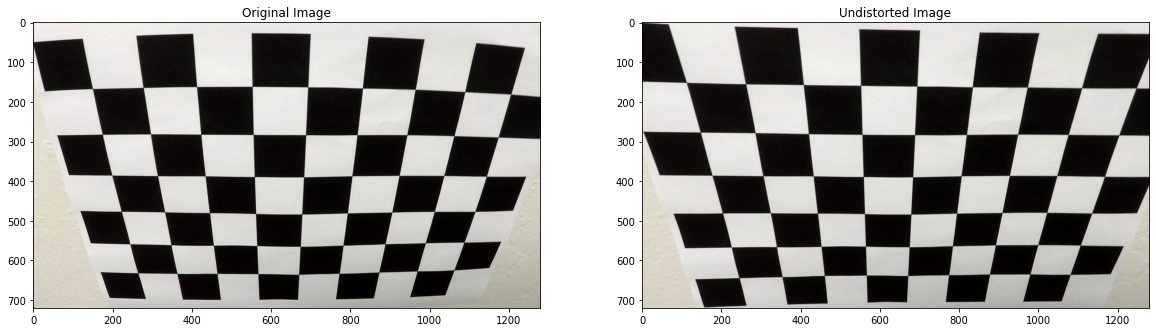

In [13]:
for i, img in tqdm.tqdm(enumerate(imgs)):
    undist = camera.undistort(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image')
    plt.savefig(os.path.join(undistort_output_dir, "image_{}".format(i)))

Following images undistortion is clearly noticeable

![undistorted4](undistort_result/camera_cal/calibration1.jpg)

In this following image, it is not that noticeable

![undistorted3](undistort_result/camera_cal/calibration10.jpg)

<a id="undistort_image"></a>
### Undistort Image

I took help from the ***lesson 6 Part 12 quiz solution***

Lets read an image

In [14]:
image_name = 'test_images/test2.jpg'

In [15]:
img = util.imread(image_name)

Undistort it using the calibration matrix

In [16]:
img = camera.undistort(img)

Let's have a look

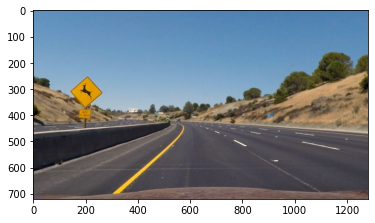

In [17]:
plt.imshow(img)

Saving the image

In [18]:
cv2.imwrite('result/undistorted_test_image.jpg',img)

True

<a id="perspective_transform"></a>
## Perspective Transform

Lets plot the image in a grid for getting the four points for the perspective transform. I took help from the project done by Jeremy shannon which is referenced [here](https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb)

In [19]:
transformer = PerspectiveTransformer()

In [20]:
transformer.set_config(img)

In [21]:
img_transformed = transformer.transform(img)

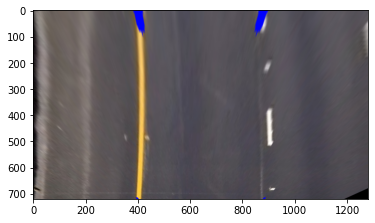

In [22]:
plt.imshow(img_transformed)

Perfect!!

In [23]:
cv2.imwrite('result/image_transformed.jpg',img_transformed)


True

<a id ="convert_to_binary"></a>
## Convert to Binary

Conversion to HLS color space and then to binary image. I took help from the quiz of ***lesson 7 part 12.*** 

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [ ]:
@interact(image=fixed(image_transformed),s1=(0,255),s2=(0,255),sx1=(0,255),sx2=(0,255),plot=fixed(True))
def r2b(image,s1=150,s2=230 ,sx1=89,sx2=220,plot=False ):
    s_thresh=(s1,s2)
    sx_thresh=(sx1,sx2)
    image = np.copy(image)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    if plot:
        plt.imshow(combined_binary)
    return combined_binary

In [ ]:
binary = r2b(image_transformed)

plotting the actual image and binary. This is also taken from lesson 7 part 11

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
ax1.imshow(image_transformed)
ax1.set_title('Original Image')
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary')

saving the binary image

In [ ]:
cv2.imwrite('result/binary.jpg',binary)

<a id="finding_lane_pixels"></a>
### Finding Lane pixels

The function to find out pixels of a lane. I took help from the ***Lesson 8 Part 4*** quiz solution 

In [ ]:
def detect_lane(binary):
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary, binary, binary))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    margin = 120
    minpix = 50

    window_height = np.int(binary.shape[0]//nwindows)
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current -margin  
        win_xleft_high = leftx_current+margin  
        win_xright_low = rightx_current -margin  
        win_xright_high = rightx_current+margin  
        

        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary):
    leftx, lefty, rightx, righty, out_img = detect_lane(binary)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit

In [ ]:
out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='blue')
plt.imshow(image_transformed)
plt.title('Lanes')
plt.savefig('result/image_transformed_with_lane.jpg')

### Let's draw the lanes in the original picture!

***I took help from jeremy shannon's [project](https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb) for this section***

At first lets create an empty mask

In [ ]:
mask = np.zeros_like(binary).astype(np.uint8)
mask_color= np.dstack((mask,mask,mask))

Lets make an array of left lane points and right lane points. Here we will have to transpose after stacking them , as in the opencv images have y dimension or number of rows are counted first.

In [ ]:
points_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
points = np.hstack((points_left,points_right))

Lets fill the polygon of the points with color green ,and the color the lanes as Red and Blue respectively

In [ ]:
mask_color=cv2.fillPoly(mask_color,np.int32([points]),(0,255,0))
mask_color=cv2.polylines(mask_color, np.int32([points_left]), isClosed=False, color=(255,0,0), thickness=10)
mask_color=cv2.polylines(mask_color, np.int32([points_right]), isClosed=False, color=(0,0,255), thickness=10)

In [ ]:
plt.imshow(mask_color)

Lets transform the mask into original perspective

In [ ]:
mask_color_previous = perspective_transform(mask_color,destination,source)

In [ ]:
plt.imshow(mask_color_previous)

Lets show the mask in the original image

In [ ]:
image_lane = cv2.addWeighted(image,1,mask_color_previous,0.5,0)

In [ ]:
plt.imshow(image_lane)

Its better for future use to make single function!

In [ ]:
def draw_lane(image,binary,left_fitx,right_fitx,ploty,source=source,destination=destination):
    mask = np.zeros_like(binary).astype(np.uint8)
    mask_color= np.dstack((mask,mask,mask))
    points_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left,points_right))
    mask_color=cv2.fillPoly(mask_color,np.int32([points]),(0,255,0))
    mask_color=cv2.polylines(mask_color, np.int32([points_left]), isClosed=False, color=(255,0,0), thickness=15)
    mask_color=cv2.polylines(mask_color, np.int32([points_right]), isClosed=False, color=(0,0,255), thickness=15)
    mask_color_previous = perspective_transform(mask_color,destination,source)
    image_lane = cv2.addWeighted(image,1,mask_color_previous,0.5,0)
    return image_lane

In [ ]:
image_lane = draw_lane(image,binary,left_fitx,right_fitx,ploty)

In [ ]:
plt.imshow(image_lane)
plt.savefig('result/image_lane.jpg')

<a id ="radius_of_curvature"></a>
## Radius of curvature

Measuring the radius of curvature. I took help from ***Lesson 8 part 7 quiz solution*** for this section

In [ ]:
def measure_curvature_pos(ploty,left_fitx,right_fitx,binary):
    xm_per_pix = 3.7/550
    ym_per_pix = 3.1/720
    
    left_fit = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)  
    
    y_eval = np.max(ploty)
   
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    H,W = binary.shape
    H= H*ym_per_pix
    left_lane_intercept =  left_fit[0]*H**2 + left_fit[1]*H + left_fit[2]
    right_lane_intercept = right_fit[0]*H**2 + right_fit[1]*H + right_fit[2]
    
    
    lane_mid_point = (left_lane_intercept+right_lane_intercept)/2
    
    vehicle_mid_point = W/2*xm_per_pix
    vehicle_position = lane_mid_point-vehicle_mid_point
    
    return left_curverad,right_curverad,vehicle_position

In [ ]:
left_curverad,right_curverad,vehicle_position = measure_curvature_pos(ploty,left_fitx,right_fitx,binary)

The curvature radius is the average of the left lane and right lane radius

In [ ]:
curv_radius = (left_curverad+right_curverad)/2


In [ ]:
text="Curvature radius {} m , and vehicle position w.r.t lane midpoint {} m".format(curv_radius,vehicle_position)

In [ ]:
text="Curve radius {:04.2f} m".format(curv_radius)
cv2.putText(image_lane, text, (50,70), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
text="vehicle position w.r.t center {:04.2f} m".format(vehicle_position)
cv2.putText(image_lane, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2, cv2.LINE_AA)

In [ ]:

plt.imshow(image_lane)

In [ ]:
cv2.imwrite('result/detected_lane_with_radius_position.jpg',image_lane)

<a id="testing_on_test_images"></a>
## Testing on the test images

In [ ]:
test_images = glob.glob('test_images/*.jpg')

In [ ]:
for test_image_name in test_images:
    test_image = imread(test_image_name)
    test_image_transformed = perspective_transform(test_image,source,destination)
    binary = r2b(test_image_transformed)
    out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary)
    test_image_lane = draw_lane(test_image,binary,left_fitx,right_fitx,ploty)
    left_curverad,right_curverad,vehicle_position=measure_curvature_pos(ploty,left_fitx,right_fitx,binary) 
    curv_radius = (left_curverad+right_curverad)/2
    
    text="Curve radius {:04.2f} m".format(curv_radius)
    cv2.putText(test_image_lane, text, (50,70), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    text="vehicle position w.r.t center {:04.2f} m".format(vehicle_position)
    cv2.putText(test_image_lane, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    
    f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(test_image)
    ax1.set_title('Original Image')
    ax2.imshow(test_image_transformed)
    ax2.set_title('Transformed Image')
    ax3.imshow(out_img, cmap='gray')
    ax3.set_title('Binary')
    ax4.imshow(test_image_lane, cmap='gray')
    ax4.set_title('Detected Lane')


<a id="video_pipeline"></a>
## Video Pipeline

Let's read the video


In [ ]:
cap = cv2.VideoCapture('project_video.mp4')

<a id="search_prior"></a>
### But wait!

From ***lesson 8 Part 5*** we learned that not all pixels in every frame is necessary to search the lane. It is enough to search around the previously detected lanes. so at first, let's get the polynomial coefficients for the first frame

In [ ]:
ret,frame = cap.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame = cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
frame_transformed = perspective_transform(frame,source,destination)
binary_frame = r2b(frame_transformed)
frame_output,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_frame)

now let's get the next frame and make it binary

In [ ]:
ret,frame = cap.read()

frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame = cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
frame_transformed = perspective_transform(frame,source,destination)
binary_frame = r2b(frame_transformed)

now let's get the nonzero values in y and x axis

In [ ]:
nonzero = binary_frame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

Now,let's get the possible left lane and right lane indices within margin of 50 pixels. [ I took this codeblock from ***lesson 8 Part 5*** quiz solution. ]

In [ ]:
margin = 50 #margin for searching the lanes
left_lane_indices = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_indices = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    

Let's get the left lane and right lane pixel values

In [ ]:
leftx = nonzerox[left_lane_indices]
lefty = nonzeroy[left_lane_indices]
rightx = nonzerox[right_lane_indices]
righty = nonzeroy[right_lane_indices]

let's get new polynomial coefficients

In [ ]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

Let's get the line

In [ ]:
ploty = np.linspace(0, binary_frame.shape[0]-1, binary_frame.shape[0])

In [ ]:
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

Let's see the output

In [ ]:
output_image = np.dstack((binary_frame,binary_frame,binary_frame))*255
output_image[nonzeroy[left_lane_indices], nonzerox[left_lane_indices]] = [255, 0, 0]
output_image[nonzeroy[right_lane_indices], nonzerox[right_lane_indices]] = [0, 0, 255]

In [ ]:
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(output_image)

Perfect! Let's make it a function to use it always!

In [ ]:
def prior_search(binary_frame,left_fit,right_fit,margin=50):
    nonzero = binary_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_indices = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_indices = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_frame.shape[0]-1, binary_frame.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx,right_fitx,ploty,left_fit,right_fit
    

Lets close the video object and read it again!

In [ ]:
cap.release()

In [ ]:
cap = cv2.VideoCapture('project_video.mp4')

Lets take the width and height of the video to create the ```VideoWriter``` object for output of the video

I took help for the following code from this [link](https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/)

In [ ]:
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('project_output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

Importing display and widgets module for display

In [ ]:
from IPython.display import display
imgbox = widgets.Image(format='jpg',height=300,width=400)

Let's get the coefficients for the first frame

In [ ]:
ret,frame = cap.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame = cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
frame_transformed = perspective_transform(frame,source,destination)
binary_frame = r2b(frame_transformed)
frame_output,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_frame)

### Line Class for tracking

As suggested in the lessons, I am declaring the line class to track the lanes

In [ ]:
from collections import deque

In [ ]:

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
         
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
        #recent number of values
        self.n=15
        #polynomial coefficients for the most recent fit
        self.current_fit = deque(maxlen=self.n) 
        
    def fit(self,fit):
        if self.best_fit is not None:
            diff = fit-self.best_fit
            if (abs(self.diffs[0]) > 0.001 or \
               abs(self.diffs[1]) > 1.0 or \
               abs(self.diffs[2]) > 100):
                self.detected = False
            else:
                self.current_fit.append(fit)
                self.best_fit = np.average(self.current_fit,axis=0)
                self.detected = True
        else:
            self.best_fit=fit
            self.current_fit.append(fit)
            self.detected= True
    def get_fitx(self,ploty): 
        best_fitx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
        return best_fitx

In [ ]:
max_count=1300

In [ ]:
count = 0

In [ ]:
left_line = Line()
right_line= Line()

In [ ]:
display(imgbox)
left_line.fit(left_fit)
right_line.fit(right_fit)
left_best_fitx=left_line.get_fitx(ploty)
right_best_fitx=right_line.get_fitx(ploty)

In [ ]:
left_fitx[-1]

In [ ]:
right_fitx[-1]

In [ ]:
while ret:
    
    
    
    if left_line.detected ==False or right_line.detected==False:

        frame_output,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_frame)
        
    else:
        left_fitx,right_fitx,ploty,left_fit,right_fit = prior_search(binary_frame,left_fit,right_fit,margin=200)
    
    if abs(abs(left_fitx[-1]-right_fitx[-1])-500)<100:
        left_line.detected=False
        right_line.detected=False
        left_line.fit(left_fit)
        right_line.fit(right_fit)
        left_best_fitx=left_line.get_fitx(ploty)
        right_best_fitx=right_line.get_fitx(ploty)
    
    frame_lane = draw_lane(frame,binary_frame,left_best_fitx,right_best_fitx,ploty)
    left_curverad,right_curverad,vehicle_position=measure_curvature_pos(ploty,left_best_fitx,right_best_fitx,binary_frame) 
    curv_radius = (left_curverad+right_curverad)/2
    text="Curve radius {:04.2f} m".format(curv_radius)
    cv2.putText(frame_lane, text, (50,70), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    text="vehicle position w.r.t center {:04.2f} m".format(vehicle_position)
    cv2.putText(frame_lane, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    frame_lane = cv2.cvtColor(frame_lane,cv2.COLOR_RGB2BGR)
    imgbox.value = frame_lane.tobytes()
    out.write(frame_lane)
    diff = left_curverad-right_curverad
    ret,frame = cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = cv2.undistort(frame,cameraMatrix,distCoeffs,None,cameraMatrix)
    frame_transformed = perspective_transform(frame,source,destination)
    binary_frame = r2b(frame_transformed)

In [ ]:
    
cap.release()
out.release()